<a href="https://colab.research.google.com/github/haiderareeb/RainForecastForTommorrow/blob/main/RainForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
#requirements
!pip install opendatasets --upgrade --quiet #for downloading datasets from kaggle
!pip install scikit-learn --upgrade --quiet #for model Training & Evaluation
!pip install matplotlib --upgrade --quiet #for DataPreprocessing

import opendatasets as od #importing opendatasets as od
import pandas as pd #importing pandas as pd for data manipulation
import numpy as np #importing numpy as np for data preprocessing
from sklearn.impute import SimpleImputer #importing SimpleImputer for filling values in null places(ex: mean)
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder #importing MinMaxScaler for standardizing the values of cols propotionally between (0,1)
#importing OneHotEncoder for Categorically encoding the cols which are non-numeric type.

In [40]:
#Data Preprocessing for
# 1) for gathering datasets
# 2) spliting datsets for training,validation & test appropriately
# 3) checking relations(inputs & targets)
# 4) fixing faults inside datasets like null values,unproportionate values,Categorically encode the non-numerical features

# Download the dataset
od.download('https://www.kaggle.com/jsphyg/weather-dataset-rattle-package') #using od to download dataset using url
raw_df = pd.read_csv('weather-dataset-rattle-package/weatherAUS.csv') #storing csv data in raw_df
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True) #deleting rows which have null values from RainToday & RainTommorrow(important feature & target)

# Create training, validation and test sets
year = pd.to_datetime(raw_df.Date).dt.year #extract year from date col
#we want model to work for future data(2018 and so) so we will split the data into train(<2015),validation(2015),test(>2015) to make it more updative
train_df, val_df, test_df = raw_df[year < 2015], raw_df[year == 2015], raw_df[year > 2015]

# Create inputs and targets
input_cols = list(train_df.columns)[1:-1] #All cols for inputs except target col and DATE col as a list
target_col = 'RainTomorrow' #target col
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy() #arranging data for train inputs and targets into different dataframes so original is fixed.
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()  #arranging data for validatiom inputs and targets into different dataframes so original is fixed.
test_inputs, test_targets = test_df[input_cols].copy(), test_df[target_col].copy() #arranging data for test inputs and targets into different dataframes so original is fixed.

# Identify numeric and categorical columns
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1] #collect numeric cols from train_inputs
categorical_cols = train_inputs.select_dtypes('object').columns.tolist() #collect objecct cols from train_input as categorical cols

# Impute missing numerical values
imputer = SimpleImputer(strategy = 'mean').fit(raw_df[numeric_cols]) #define imputer object with strategy and cols to perform on
#perform for each split dataset on the specified cols
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

# Scale numeric features: standardizing (0,1)
scaler = MinMaxScaler().fit(raw_df[numeric_cols]) #define Scaler object with cols
# perform on each dataset on speciified cols
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

# One-hot encode categorical features (categoricalcols(object type cols) into OneHotEncoding)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(raw_df[categorical_cols]) #define encoder object with strategy and cols
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
#perform transform on each dataset on specified cols
encoded_train = pd.DataFrame(encoder.transform(train_inputs[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols), index=train_inputs.index)
encoded_val = pd.DataFrame(encoder.transform(val_inputs[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols), index=val_inputs.index)
encoded_test = pd.DataFrame(encoder.transform(test_inputs[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols), index=test_inputs.index)

# Concatenate numeric and one-hot encoded categorical columns into single dataframe
train_inputs = pd.concat([train_inputs[numeric_cols], encoded_train], axis=1)
val_inputs = pd.concat([val_inputs[numeric_cols], encoded_val], axis=1)
test_inputs = pd.concat([test_inputs[numeric_cols], encoded_test], axis=1)

# Save processed data to disk using parquet
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')
test_inputs.to_parquet('test_inputs.parquet')
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')
pd.DataFrame(test_targets).to_parquet('test_targets.parquet')

# Load processed data from disk using parquet
train_inputs = pd.read_parquet('train_inputs.parquet')
val_inputs = pd.read_parquet('val_inputs.parquet')
test_inputs = pd.read_parquet('test_inputs.parquet')
train_targets = pd.read_parquet('train_targets.parquet')[target_col]
val_targets = pd.read_parquet('val_targets.parquet')[target_col]
test_targets = pd.read_parquet('test_targets.parquet')[target_col]

Skipping, found downloaded files in "./weather-dataset-rattle-package" (use force=True to force download)


In [41]:
#Data Visulization & Analysis
import plotly.express as px #api
import matplotlib #for Data visulaization
import matplotlib.pyplot as plt #for plotting graph
import seaborn as sns #for creating more visually appealing graphs(ex: heatmap)
#for to show graph inside output cell.
%matplotlib inline

#some conventions designs for graphs
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

#plotting histogram to check RainToday proportion in different location
px.histogram(raw_df,
             x='Location', # x-axis measure location-wise & y-axis  measure count of RainToday or not in this case
             title='Location vs. Rainy Days', #title of plot
             color='RainToday' #colors the area based on Rain Today values (yes or no)
            )

#plotting histogram to check RainTommorrow proportion based on Temp3pm
px.histogram(raw_df,
             x='Temp3pm',  #x-axis measure Temp3Pm & y-axis  measure count of RainTommorrow or not in this case
             title='Temperature at 3 pm vs. Rain Tomorrow', #title of plot
             color='RainTomorrow' #colors the area based on Rain Tommorrow values (yes or no)
             )

#plotting histogram to check RainTommorrow vs RainToday proportion
px.histogram(raw_df,
             x='RainTomorrow',  #x-axis measure RainTommorow-wise (Yes or no) & y-axis  measure count of RainToday  or not in this case
             color='RainToday',  #colors the area based on Rain Today values (yes or no)
             title='Rain Tomorrow vs. Rain Today')#title of plot

#plotting histogram to check RainToday proportion based on MAxTemp and MinTemp
px.scatter(raw_df.sample(2000),  #only take 2000 records and plot
           title='Min Temp. vs Max Temp.',
           x='MinTemp',
           y='MaxTemp',
           color='RainToday')

#plotting histogram to check RainToday proportion based on Humidity3pm and Temmp3pm
px.scatter(raw_df.sample(2000),
           title='Temp (3 pm) vs. Humidity (3 pm)',
           x='Temp3pm',
           y='Humidity3pm',
           color='RainTomorrow')




Accuracy: 85.41%
Accuracy: 84.25%


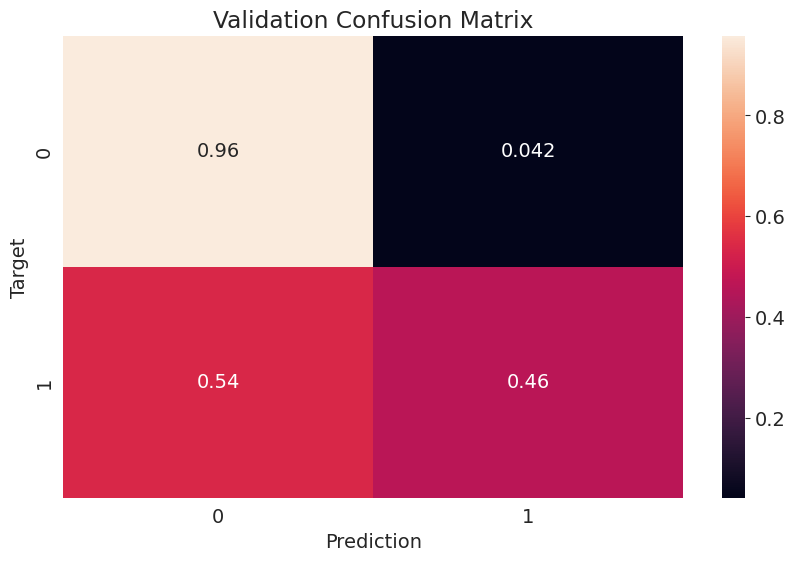

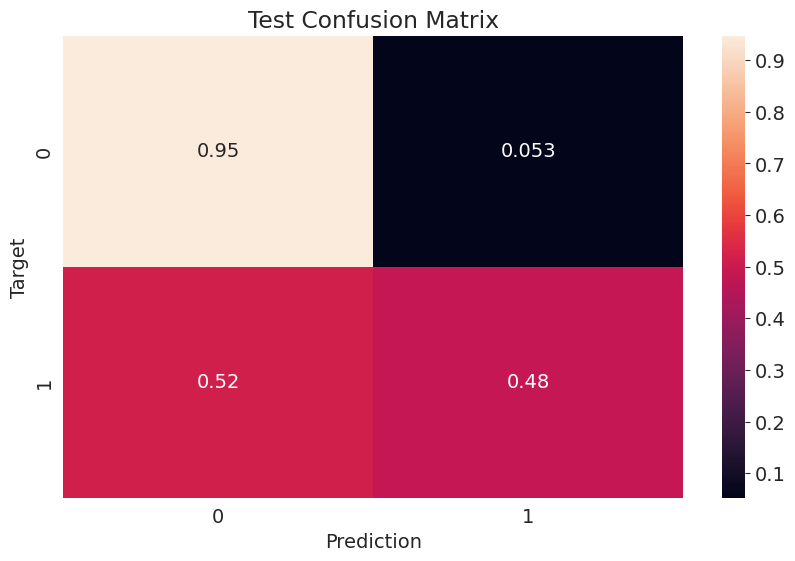

In [42]:
#Model Training & Evaluation
from sklearn.linear_model import LogisticRegression #using Logistic Regression model for a classification problem like this
from sklearn.metrics import accuracy_score,confusion_matrix #use accuracy score,confusion matrix to check your model accuracy
import matplotlib.pyplot as plt #plotting
import joblib #joblib module to save and load Python objects(such as model) on the disk
import seaborn as sns #visualization

# Create and train the model
model = LogisticRegression(solver='liblinear')
model.fit(train_inputs, train_targets)

# Generate predictions and probabilities
train_preds = model.predict(train_inputs)
train_probs = model.predict_proba(train_inputs)
accuracy_score(train_targets, train_preds)

# Helper function to predict, compute accuracy & plot confustion matrix
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    return preds

# Evaluate on validation and test set
val_preds = predict_and_plot(val_inputs, val_targets, 'Validation')
test_preds = predict_and_plot(test_inputs, test_targets, 'Test')

# Save the trained model & load it back
RainForecastForTommorrow= {'model': model, 'imputer': imputer, 'scaler': scaler, 'encoder': encoder,
               'input_cols': input_cols, 'target_col': target_col, 'numeric_cols': numeric_cols,
               'categorical_cols': categorical_cols, 'encoded_cols':encoded_cols}
joblib.dump(RainForecastForTommorrow, 'RainForecastForTommorrow.joblib')
aussie_rain2 = joblib.load('RainForecastForTommorrow.joblib')

In [64]:
#Prediction on Single Inputs
def predict_input(single_input):
    #pre-process the Input data
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    # Encode categorical columns
    encoded_df = pd.DataFrame(encoder.transform(input_df[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols), index=input_df.index)
    # Concatenate numeric and encoded columns
    input_df = pd.concat([input_df[numeric_cols], encoded_df], axis=1)
    # Prepare input for prediction
    X_input = input_df[numeric_cols + encoded_cols]
    # Predict and return result
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'No'}

predict_input(new_input)

('Yes', 0.5107396283855985)